In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")
from utils import data_dir

from tqdm import tqdm
from tabulate import tabulate

In [122]:
task_name = "axion2"
model_layer = "F_7"

## Grab our data

In [123]:
pfn_outputs = np.load(f"pfn_layer_outputs/{task_name}_{model_layer}_10%.npy")
pfn_outputs = pfn_outputs.T

# Stylize these labels for the sake of LaTeX
if "_" in model_layer:
    part, idx = model_layer.split("_")  # Something like ("F", "7")
    model_layer = f"{part}{idx}"
pfn_labels = [f"{model_layer}({i})" for i in range(pfn_outputs.shape[0])]

print("PFN outputs shape:", pfn_outputs.shape)

PFN outputs shape: (128, 30000)


In [191]:
bdt_vars = []
for particle in ["pi0", "gamma", task_name]:
    bdt_var_npz = np.load(f"{data_dir}/processed/bdt_vars/{particle}_bdt_vars.npz")
    bdt_var_labels = list(bdt_var_npz.keys())
    bdt_vars.append(np.vstack([bdt_var_npz[key] for key in bdt_var_labels])[:,::10])

bdt_vars = np.hstack(bdt_vars)
print("BDT vars shape: ", bdt_vars.shape)

BDT vars shape:  (53, 30000)


In [192]:
# Mask out things that are all zeros
def filter_zero_var(arr, labels):
    """
    arr.shape == (n_features, n_samples)
    len(labels) == n_features
    
    Filter out all features having zero variance.
    """
    # Filter for zero variance
    all_zero_mask = np.nanvar(arr, axis=1) < 1e-6
    return (
        arr[~all_zero_mask],
        [labels[i] for i in np.where(~all_zero_mask)[0]],
        all_zero_mask
    )

pfn_outputs, pfn_labels, _ = filter_zero_var(pfn_outputs, pfn_labels)
bdt_vars, bdt_var_labels, _ = filter_zero_var(bdt_vars, bdt_var_labels)

In [193]:
all_vars = np.vstack([pfn_outputs, bdt_vars])
all_labels = pfn_labels + bdt_var_labels

# Impute missing values
nan_locs = np.where(np.isnan(all_vars))
for feature, sample in zip(*nan_locs):
    all_vars[feature,sample] = np.nanmean(all_vars[feature,:])
    
assert not np.any(np.isnan(all_vars))

In [194]:
print(all_vars.shape)

(162, 30000)


## Evaluate correlations

In [183]:
# Wooooo...
corr_mat = np.corrcoef(all_vars)

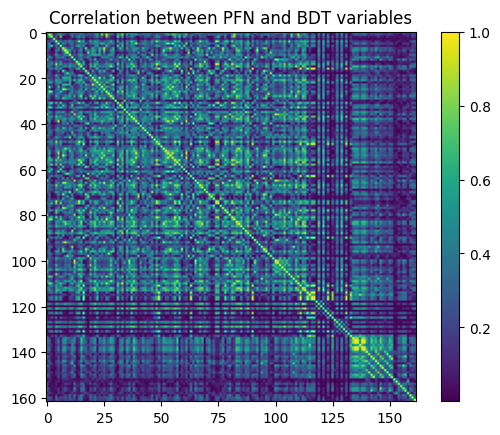

In [184]:
plt.imshow(np.abs(corr_mat))
plt.colorbar()
plt.title(f"Correlation between PFN and BDT variables");

There's a couple variables with zero variance amongst the BDT variables, but that's ok.

In [185]:
def corr(var1, var2):
    return corr_mat[all_labels.index(var1),all_labels.index(var2)]

In [186]:
def plot_corr(var1, var2, ax):
    idx1, idx2 = all_labels.index(var1), all_labels.index(var2)
    ax.scatter(all_vars[idx1], all_vars[idx2], s=0.1, linewidth=0)
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)
    ax.set_title(f"{task_name} PFN, layer {model_layer}")

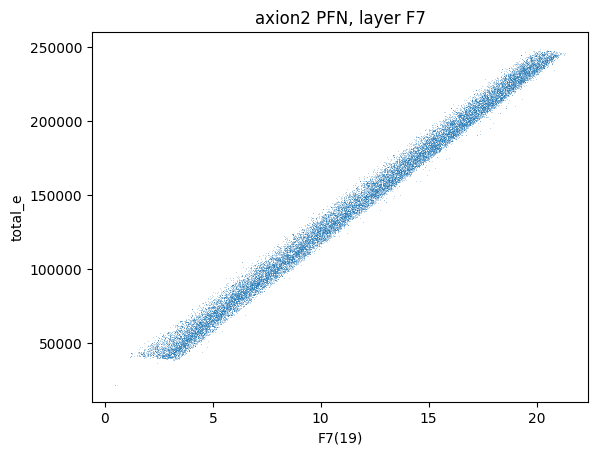

In [196]:
fig, ax = plt.subplots()
plot_corr("F7(19)", "total_e", ax)

## For each PFN variable, find which BDT var it correlates most highly with

In [201]:
table = []

for var1 in pfn_labels:
    idx1 = all_labels.index(var1)
    idx2 = np.argmax(corr_mat[idx1,len(pfn_labels):]) + len(pfn_labels)
    var2 = all_labels[idx2]
    corr = corr_mat[idx1,idx2]
    table.append([var1, var2, corr])

table.sort(key=lambda row: -abs(row[2]))

# Top 9
print(tabulate(table[:9], headers=["PFN unit", "BDT variable", "correlation"]))

PFN unit    BDT variable              correlation
----------  ----------------------  -------------
F7(73)      depth_weighted_total_e       0.998948
F7(106)     depth_weighted_total_e       0.99636
F7(19)      total_e                      0.996346
F7(59)      secondlayer_e                0.991736
F7(96)      firstlayer_x2                0.907271
F7(99)      firstlayer_x2                0.890862
F7(121)     firstlayer_y2                0.886877
F7(126)     prelayer_e                   0.876291
F7(95)      prelayer_e                   0.870709
